# Analysis of lines spoken by main characters by season

We'll parse the Simpsons database of episodes and scripts to look at how the dialogue varies for the main characters by episode and season.

In [2]:
# imports
import bs4
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib
import time
sns.set()
%matplotlib inline
import psycopg2
from sqlalchemy import create_engine

## Connect to PostgreSQL database of Simpsons scripts

In [3]:
# connect to postgresl
dbname = 'simpsonsscripts'
username = 'hsf001'

con = None
con = psycopg2.connect(database = dbname, user = username)

engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://hsf001@localhost/simpsonsscripts


## Pull scripts from one season and sort by character

We'll focus on one season and count how many lines are attributed to each of the main characters (Homer Simpson, Marge Simpson, Bart Simpson, and Lisa Simpson) in each episode.

In [13]:
# SQL query for script from one episode: Season 5, Episode 5

sql_query = """
SELECT ep.season, ep.number, ep.name, scripts.text FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5' AND ep.number='5'
"""
output_from_sql = pd.read_sql_query(sql_query,con)
output_from_sql.head()

,season,number,name,text
0,5,5,Treehouse of Horror IV,"Richard Nixon: Yes, Master."
1,5,5,Treehouse of Horror IV,(NIGHT GALLERY-TYPE SET: int. night gallery-ty...
2,5,5,Treehouse of Horror IV,Bart Simpson: Paintings. Lifeless images rend...
3,5,5,Treehouse of Horror IV,Bart Simpson: They become portals to hell so ...
4,5,5,Treehouse of Horror IV,Marge Simpson: Bart! You should warn people t...


In [144]:
# SQL query for number of lines for a character for each episode in a season

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Homer Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

home_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Marge Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

marg_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Bart Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

bart_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Lisa Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

lisa_sea05 = pd.read_sql_query(sql_query,con)

sql_query = """
SELECT ep.number, COUNT(*) FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Maggie Simpson: %'
  GROUP BY ep.number
  ORDER BY ep.number
"""

magg_sea05 = pd.read_sql_query(sql_query,con)

# SQL query to get episode names

sql_query = """
SELECT number, name FROM episodes WHERE season='5'
"""

name_sea05 = pd.read_sql_query(sql_query,con)
name_sea05.head()

,number,name
0,1,Homer's Barbershop Quartet
1,2,Cape Feare
2,3,Homer Goes to College
3,4,Rosebud
4,5,Treehouse of Horror IV


In [ ]:
# example for data format and stacked bar plot
#df = pd.DataFrame(columns=["Character","One","Two","Three"],
#                  data=[["Homer",1,2,3],
#                        ["Marge",1,3,5]])
#sns.set()
#df.set_index('Character').T.plot(kind='bar', stacked=True)

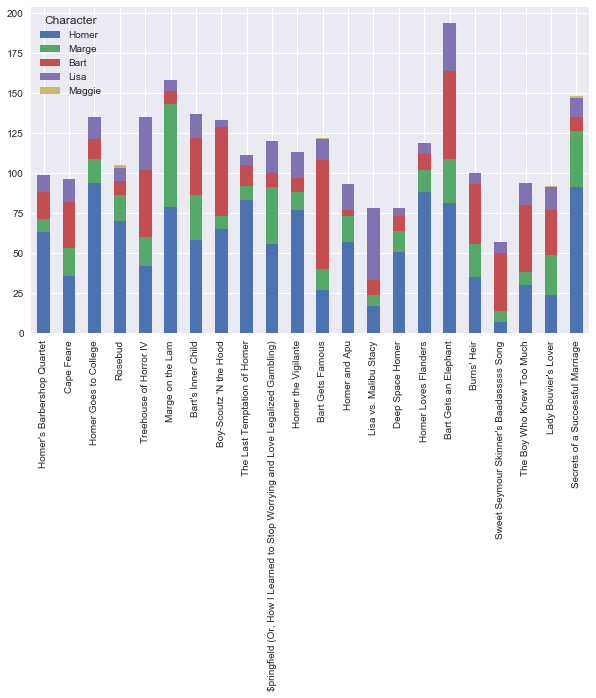

In [206]:
# make episode number integer
home_sea05['number']=home_sea05['number'].astype(int)
marg_sea05['number']=marg_sea05['number'].astype(int)
bart_sea05['number']=bart_sea05['number'].astype(int)
lisa_sea05['number']=lisa_sea05['number'].astype(int)
magg_sea05['number']=magg_sea05['number'].astype(int)

# sort lines per character by episode number
home_sea05.sort_values(by='number', inplace=True)
marg_sea05.sort_values(by='number', inplace=True)
bart_sea05.sort_values(by='number', inplace=True)
lisa_sea05.sort_values(by='number', inplace=True)
magg_sea05.sort_values(by='number', inplace=True)

# create dataframe from data
columns=["Character"]
columns.extend(name_sea05['name'].tolist())
homer=["Homer"]
homer.extend(home_sea05['count'].tolist())
marge=["Marge"]
marge.extend(marg_sea05['count'].tolist())
bart=["Bart"]
bart.extend(bart_sea05['count'].tolist())
lisa=["Lisa"]
lisa.extend(lisa_sea05['count'].tolist())

# fix maggie's lines since she doesn't have lines in all episodes

n_ep = max(home_sea05['number'])

magg_sea05_lines = []

for ii in range(n_ep):
    if (ii+1) in magg_sea05['number'].tolist():
        #magg_sea05_lines.append(magg_sea05['count'][ii+1])
        magg_sea05_lines.append(magg_sea05[magg_sea05['number']==(ii+1)]['count'].values[0])
    else:
        magg_sea05_lines.append(0)

maggie=["Maggie"]
maggie.extend(magg_sea05_lines)

df = pd.DataFrame(columns=columns,
                  data=[homer,
                        marge,
                        bart,
                        lisa,
                        maggie])

# plot stacked bar chart of character lines by episode name
sns.set()
fig,ax=plt.subplots(figsize=(10,6))
df.set_index('Character').T.plot(kind='bar', stacked=True, ax=ax)


In [147]:
# SQL query to get Maggie's lines in season 5

sql_query = """
SELECT ep.number, ep.name, scripts.text FROM episodes ep  
  LEFT JOIN scripts ON ep.url = scripts.url WHERE ep.season='5'
  AND scripts.text LIKE 'Maggie Simpson: %'
"""

query = pd.read_sql_query(sql_query,con)
query.head()

,number,name,text
0,12,Bart Gets Famous,Maggie Simpson: (SUCK)
1,4,Rosebud,Maggie Simpson: (WHIMPERS)
2,4,Rosebud,Maggie Simpson: (SOBS)
3,21,Lady Bouvier's Lover,Maggie Simpson: (SCARED SOUNDS)
4,22,Secrets of a Successful Marriage,"Maggie Simpson: (TWO SLOW, NON COMMITTAL SUCKS)"


### Start with 1 season

### Focus on first 15 seasons